## Experiments using `sklearn` for image classification

In [1]:
%matplotlib inline

In [2]:
import time
import warnings
import operator
import pickle
from functools import partial, wraps

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
np.set_printoptions(precision=3, suppress=True)

In [4]:
sns.set_context('notebook', font_scale=1.5)

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import FeatureAgglomeration
from sklearn.feature_selection import (SelectKBest, SelectFromModel, 
                                       SelectFdr, SelectPercentile, 
                                       f_classif, mutual_info_classif, RFE, RFECV)
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import (StratifiedKFold, cross_val_score, 
                                     cross_val_predict, GridSearchCV)
from sklearn.linear_model import (LassoCV, RidgeClassifier, RidgeClassifierCV, 
                                  RandomizedLogisticRegression)
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, make_scorer

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, 
                              AdaBoostClassifier, ExtraTreesClassifier)
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.pipeline import Pipeline

## Read data

In [6]:
df = pd.read_csv('dat2_features_no_blue_all.csv')

In [7]:
df.shape

(312, 4062)

In [8]:
df.groupby('class')['class_id'].mean()

class
blue_bg                   1.0
distal_acinar_tubule2     2.0
proximal_acinar_tubule    3.0
Name: class_id, dtype: float64

In [9]:
X = df.ix[:, :-3]
y = df.ix[:, -3].astype('int')

## Preprocessing

In [10]:
scaler = StandardScaler()
scaler.fit(X)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [11]:
X_scaled = scaler.transform(X)

In [12]:
X_scaled.mean(axis=0)

array([ 0.,  0., -0., ..., -0., -0., -0.])

In [13]:
X_scaled.std(axis=0)

array([ 1.,  1.,  1., ...,  1.,  1.,  1.])

## Dimension reduction expriments

In [14]:
pca = PCA(n_components=2)
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [15]:
X_pca = pca.transform(X_scaled)

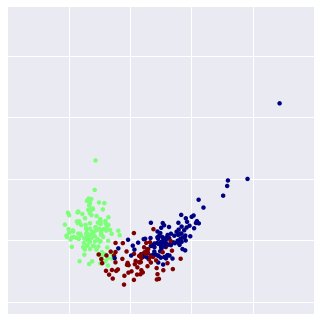

In [16]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], edgecolors='none', c=y, s=20, cmap='jet')
plt.axis('square')
ax =plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
pass

In [17]:
tsne = TSNE(n_components=2, random_state=1)

In [18]:
X_tsne = tsne.fit_transform(X_scaled)

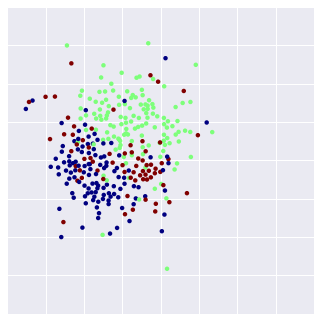

In [19]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], edgecolors='none', c=y, s=20, cmap='jet')
plt.axis('square')
ax =plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
pass

In [20]:
agg = FeatureAgglomeration(n_clusters=2)

In [21]:
X_agg = agg.fit_transform(X_scaled)

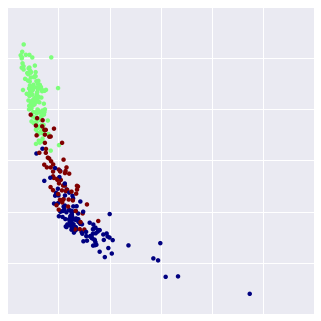

In [22]:
plt.scatter(X_agg[:, 0], X_agg[:, 1], edgecolors='none', c=y, s=20, cmap='jet')
plt.axis('square')
ax =plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
pass

## Feature selection experiments

In [23]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    sb = SelectKBest(f_classif, k=2).fit(X_scaled, y)
    idx = sb.get_support()
    X_best = sb.transform(X_scaled)

In [24]:
features = df.columns[:-3]
features[idx]

Index(['Haralick Textures (Chebyshev ()) [14]', 'Pixel Intensity Statistics (Fourier (Chebyshev ())) [2]'], dtype='object')

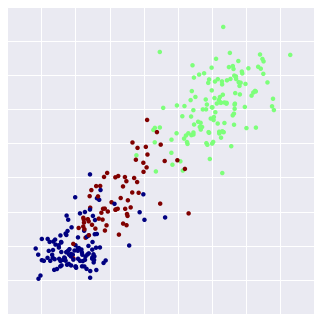

In [25]:
plt.scatter(X_best[:, 0], X_best[:, 1], edgecolors='none', c=y, s=20, cmap='jet')
plt.axis('square')
ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
pass

In [26]:
skb_mi = SelectKBest(mutual_info_classif, k=2).fit(X_scaled, y)
X_mi = skb_mi.transform(X_scaled)
idx = skb_mi.get_support()
features[idx]

Index(['Color Histogram () [5]', 'Pixel Intensity Statistics (Chebyshev (Fourier ())) [2]'], dtype='object')

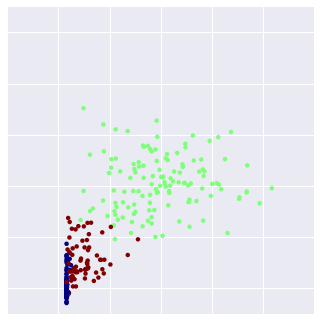

In [27]:
plt.scatter(X_mi[:, 0], X_mi[:, 1], edgecolors='none', c=y, s=20, cmap='jet')
plt.axis('square')
ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
pass

In [28]:
# svc = SVC(kernel="linear", C=1)
# X_rfe = (RFE(estimator=svc, n_features_to_select=2)
#          .fit_transform(X_scaled, y))

In [29]:
# plt.scatter(X_rfe[:, 0], X_rfe[:, 1], edgecolors='none', c=y, s=20, cmap='jet')
# plt.axis('square')
# ax =plt.gca()
# ax.set_xticklabels([])
# ax.set_yticklabels([])
# pass

In [30]:
# rlr = RandomizedLogisticRegression()
# rlr.fit(X_scaled, y)
# idx = np.argsort(rlr.scores_)[::-1]
# X_rlr = X_scaled[:, idx]

In [31]:
# df.columns[idx[:10]]

In [32]:
# np.unique(rlr.scores_)[::-1][:5]

In [33]:
# plt.scatter(X_rlr[:, 0], X_rlr[:, 1], edgecolors='none', c=y, s=20, cmap='jet')
# plt.axis('square')
# ax = plt.gca()
# ax.set_xticklabels([])
# ax.set_yticklabels([])
# pass

## Classification experiments

In [34]:
lasso = LassoCV()
sfm_lasso = SelectFromModel(lasso, threshold=0.01)
X_lasso = sfm_lasso.fit_transform(X_scaled, y)

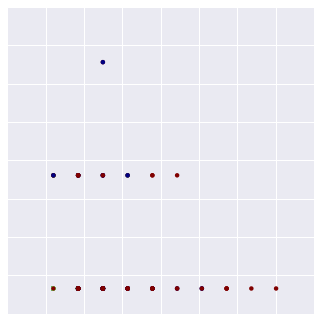

In [35]:
plt.scatter(X_lasso[:, 0], X_lasso[:, 1], edgecolors='none', c=y, s=20, cmap='jet')
plt.axis('square')
ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
pass

In [36]:
rf = RandomForestClassifier(random_state=1)
rf.fit(X_scaled, y)
sfm_rf = SelectFromModel(rf, prefit=True)
X_rf = sfm_rf.transform(X_scaled)

In [37]:
idx = np.argsort(rf.feature_importances_[rf.feature_importances_ > 0])[::-1]
X_rf = X_rf[:, idx]

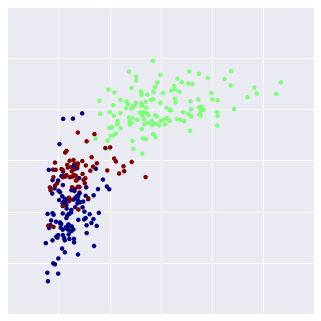

In [38]:
plt.scatter(X_rf[:, 0], X_rf[:, 1], edgecolors='none', c=y, s=20, cmap='jet')
plt.axis('square')
ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
pass

## Classification pipeline experiments

In [39]:
alpha = [0.01, 0.1, 1.0, 10.0, 100.0]
Cs = [0.01, 0.1, 1.0, 10.0, 100.0]
gamma = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
learning_rate_init = [1e-4, 1e-3, 1e-2, 1e-1]
max_depth = [1, 5, 10, 'log2', 'sqrt', None]
max_features = [1, 5, 10, 'sqrt', 'log2', None]
n_estimators = [5, 10, 25]
n_neighbors = [3, 5, 7, 9, 11]

ridge_params = {'alpha': alpha}
svc_params = [{'kernel': ['rbf'], 'gamma': gamma, 'C': Cs},
              {'kernel': ['linear'], 'C': Cs}]
tree_params = {'max_depth': max_depth, 'n_estimators' : n_estimators, 
               'max_features': max_features}
nn_params = {'alpha': alpha, 'learning_rate_init': learning_rate_init}
knn_params = {'n_neighbors': n_neighbors}

NameError: name 'alphas' is not defined

In [ ]:
clfs = [
    GridSearchCV(RidgeClassifier(), ridge_params, cv=5, n_jobs=5),
    GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, n_jobs=5),
    GridSearchCV(SVC(), svc_params, cv=5, n_jobs=5),
    GridSearchCV(DecisionTreeClassifier(), tree_params, cv=5, n_jobs=5),
    GridSearchCV(RandomForestClassifier(), tree_params, cv=5, n_jobs=5),
    GridSearchCV(MLPClassifier(max_iter=1000), nn_params, cv=5, n_jobs=5),
    AdaBoostClassifier(),
    GaussianNB(),
    ]

In [ ]:
try:
    with open('socres.pic', 'rb') as f:
        scores = pickle.loda(f)
except:
    scores = {}

for clf in clfs:
    with warnings.catch_warnings():
        print(clf.__class__.__name__)
        warnings.simplefilter('ignore')
        pipe = Pipeline([
          ('standard_scalar', StandardScaler()),
          ('feature_selection', SelectFdr()),
          ('classification', clf)
        ])
        if repr(pipe) in scores:
            continue
        start = time.clock()
        pipe.fit(X, y, )
        score = cross_val_score(pipe, X, y, scoring='accuracy', n_jobs=-1)
        elapsed = time.clock() - start
        scores[repr(pipe)] = score.mean(), elapsed, score
with open('scores.pic', 'wb') as f:
    pickle.dump(scores, f)

## Sort by average cross-validation accuracy

In [ ]:
for k, v in sorted(scores.items(), key=lambda x: x[1][0], reverse=True):
    print('%s\n' % k, '%.2f' % v[0], '%8.2f' % v[1], v[2], '\n')

## Sort by time taken

In [ ]:
for k, v in sorted(scores.items(), key=lambda x: x[1][1], reverse=False):
    print('%-40s' % k, '%8.2f' % v[0], '%8.2f' % v[1], v[2])